In [550]:
# imports
import csv
import json
import os
import pandas as pd
import scipy.stats as stats
import numpy as np

In [551]:
# setting local path— change to reflect your locoal Protocols repo clone
protocols_path = '/Users/nickdiehl/protocols/protocols'

# sessions report from Google Analytics
marketing_csv_path = '/Users/nickdiehl/protocols/data/csv/sessions_by_page.csv'


In [552]:
# filling dictionary of protocol IDs with counts of textFile type fields

protocol_data = {}

for folder in os.listdir(protocols_path):
    folder_path = f'{protocols_path}/{folder}'
    if os.path.isdir(folder_path):
        protocol_data[folder] = {'count': 0}
        for file in os.listdir(folder_path):
            if file == 'fields.json':
                fields_filepath = f'{folder_path}/{file}'
                with open(fields_filepath) as fields_file:
                    fields_data = json.load(fields_file)
                    for field in fields_data:
                        if field['type'] == 'textFile':
                            protocol_data[folder]['count'] += 1

In [553]:
# create dataframe containing protocol IDs and csv-count

df_dict = {'id': protocol_data.keys(), 'csv-count': [val['count'] for val in protocol_data.values()]}
df = pd.DataFrame(df_dict)
print(df)
print(df.groupby('csv-count').count())

                id  csv-count
0           58d57d          0
1      2aee74-48-2          0
2           1440ad          0
3           74b303          1
4    04eeb1-part-6          0
..             ...        ...
653    9778eb_spri          0
654         3c9aec          0
655         355b30          0
656         04f4e7          0
657  43d313-part-3          0

[658 rows x 2 columns]
            id
csv-count     
0          570
1           79
2            6
3            1
4            2


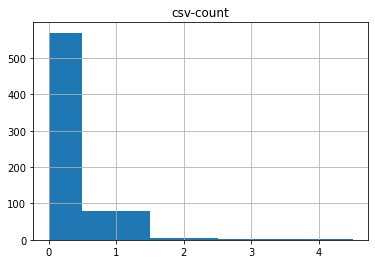

In [554]:
hist = df.hist(column='csv-count', bins=[0, 0.5, 1.5, 2.5, 3.5, 4.5])

In [555]:
# filter analytics info to look for pages of the form: "opentrons"

marketing_data = pd.read_csv('https://raw.githubusercontent.com/Opentrons/Protocols/data-analytics/data/csv/sessions_by_page.csv').to_csv(index=False).splitlines()

marketing_ids = []
marketing_sessions = []
reader = csv.reader(marketing_data)
for line in reader:
    split_line = line[0].split('/protocol')
    if len(split_line) > 1:
        id = split_line[1].split('/')[-1]
        sessions = int(line[1].replace(',', ''))
        marketing_ids.append(id)
        marketing_sessions.append(sessions)

df_marketing = pd.DataFrame({'id': marketing_ids, 'sessions': marketing_sessions})

In [556]:
# contains PL search hits as well

print(df_marketing)

                                                     id  sessions
0                      customizable_serial_dilution_ot2      4599
1         nucleic_acid_purification_with_magnetic_beads      2818
2                                         cherrypicking      2790
3                    omega_biotek_magbind_totalpure_NGS      1528
4                                         normalization      1521
...                                                 ...       ...
1694                              swift-fully-automated         1
1695  Basic Pipetting+&cd=2&hl=ru&ct=clnk&gl=it&clie...         1
1696       &cd=1&hl=en&ct=clnk&gl=nl&client=firefox-b-d         1
1697             search?q=pcr &cd=2&hl=nl&ct=clnk&gl=nl         1
1698            &usg=ALkJrhhFwLLy0tdWwT-P_cgZv3vekomMEQ         1

[1699 rows x 2 columns]


In [557]:
# merge Protocols Repo data w/ Protocol Library Analytics data on protocol ID 

df_total = pd.merge(df, df_marketing, on='id', how='inner')
df_total

,id,csv-count,sessions
0,58d57d,0,19
1,2aee74-48-2,0,1
2,1440ad,0,57
3,74b303,1,57
4,04eeb1-part-6,0,5
...,...,...,...
657,9778eb_spri,0,2
658,3c9aec,0,23
659,355b30,0,60
660,04f4e7,0,10


In [558]:
# create Boolean series representing whether protocol >= 1 textFile input field
# drop NaN values (shouldn't be any)

df_total['has-csv'] = df_total['csv-count'] > 0
df_total.dropna(inplace=True)
df_total

,id,csv-count,sessions,has-csv
0,58d57d,0,19,False
1,2aee74-48-2,0,1,False
2,1440ad,0,57,False
3,74b303,1,57,True
4,04eeb1-part-6,0,5,False
...,...,...,...,...
657,9778eb_spri,0,2,False
658,3c9aec,0,23,False
659,355b30,0,60,False
660,04f4e7,0,10,False


In [559]:
# analysis to determine significance of PL sessions created for CSV protocols vs non-CSV protocols
test_group_csv_true = df_total[df_total['has-csv']]['sessions']
test_group_csv_false = df_total[df_total['has-csv']==False]['sessions']

# determine whether or not we have populations of equal variance (ratio < 4)
variance_ratio = max([np.var(test_group_csv_true), np.var(test_group_csv_false)])/min([np.var(test_group_csv_true), np.var(test_group_csv_false)])
print(f'variance ratio: {variance_ratio}')

variance ratio: 1.9806581289900647


In [560]:
# variance ratio = 1.98 < 4.0, so equal variances apply: Two-Sample T-Test of equal variance

ttest = stats.ttest_ind(a=df_total[df_total['has-csv']==False]['sessions'], b=df_total[df_total['has-csv']]['sessions'], equal_var=True)
print(f'test statistic: {ttest.statistic}')
print(f'p-value: {ttest.pvalue}')

test statistic: -2.533114324587434
p-value: 0.01153585063673606


In [561]:
df_total[df_total['has-csv']==False].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571 entries, 0 to 661
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         571 non-null    object
 1   csv-count  571 non-null    int64 
 2   sessions   571 non-null    int64 
 3   has-csv    571 non-null    bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 18.4+ KB


In [562]:
# statistics about CSV protocols
df_total[df_total['has-csv']]['sessions'].describe()

count      91.000000
mean      136.648352
std       359.217711
min         1.000000
25%        17.000000
50%        47.000000
75%        91.500000
max      2790.000000
Name: sessions, dtype: float64

In [563]:
# statistics about non-CSV protocols
df_total[~df_total['has-csv']]['sessions'].describe()

count     571.000000
mean       59.217163
std       254.058755
min         1.000000
25%         6.000000
50%        17.000000
75%        41.500000
max      4599.000000
Name: sessions, dtype: float64